# HIV SMILES String dataset:<br> CNNLSTMAutoencoder for new molecle generation and GCN classification

# Dealing with the Dataset

## Load HIV dataset

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv("HIV.csv")
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [3]:
string = df.loc[0,'smiles']
print(df.loc[0,'smiles'])
print(string[3])

CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2
1


In [4]:
df.value_counts("activity")

activity
CI    39684
CM     1039
CA      404
Name: count, dtype: int64

In [5]:
df.value_counts("HIV_active")

HIV_active
0    39684
1     1443
Name: count, dtype: int64

## Transform into SELFIES representation

In [6]:
import selfies as sf

In [7]:
# transform
df_sf = df.copy()
len_sf=[]
for ind in range(len(df_sf['smiles'])):
    try:
       df_sf.loc[ind, 'smiles'] = sf.encoder(df_sf.loc[ind, 'smiles'])
    except:
        pass #sf.encoder error!

    len_sf.append(sf.len_selfies(df_sf.loc[ind, 'smiles']))

In [8]:
df_sf.rename({'smiles':'selfies'}, axis='columns', inplace=True)
df_sf.head()

,selfies,activity,HIV_active
0,[C][C][C][=O+1][Cu-3][Branch1][#Branch2][O+1][...,CI,0
1,[C][=Branch1][#Branch2][=C][C][=C][C][=C][C][=...,CI,0
2,[C][C][=Branch1][C][=O][N][C][=C][C][=C][C][=C...,CI,0
3,[N][C][=C][C][=C][Branch2][Ring1][=Branch1][C]...,CI,0
4,[O][=S][=Branch1][C][=O][Branch1][C][O][C][C][...,CI,0


In [9]:
string_sf = df_sf.loc[0,'selfies']
print(df_sf.loc[0,'selfies'])
#print(string_sf)

[C][C][C][=O+1][Cu-3][Branch1][#Branch2][O+1][=C][Branch1][Ring1][C][C][C][Ring1][Branch2][O+1][=C][Branch1][Ring1][C][C][C][C][Branch1][Ring1][C][C][=O+1][Ring1][#C]


In [10]:
# Compute mean and standard deviation
print(np.mean(len_sf))
print(np.std(len_sf))

41.75984146667639
21.70874260604909


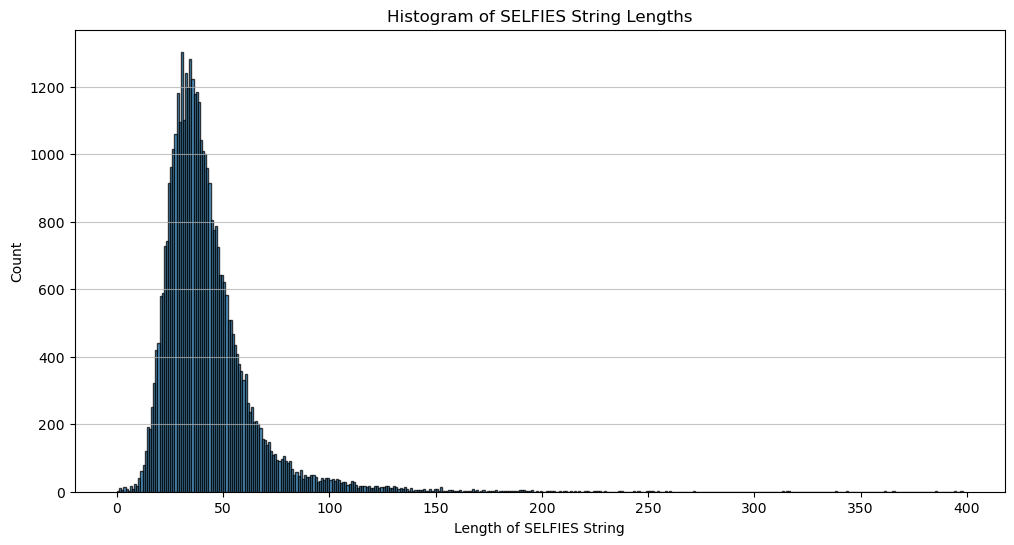

In [11]:
# Create a histogram
plt.figure(figsize=(12, 6))
plt.hist(len_sf, bins=range(min(len_sf), max(len_sf) + 1), alpha=0.75, edgecolor='black')
plt.title('Histogram of SELFIES String Lengths')
plt.xlabel('Length of SELFIES String')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Data sampling for the CNN-LSTM Autoencoder

In [12]:
# Separate the dataframe into three categories
df_CI = df_sf[df_sf['activity'] == 'CI']
df_CM = df_sf[df_sf['activity'] == 'CM']
df_CA = df_sf[df_sf['activity'] == 'CA']

# Randomly sample 300 from each category
sample_CI = df_CI.sample(n=300, random_state=42)  # replace 1 with your chosen seed for reproducibility
sample_CM = df_CM.sample(n=300, random_state=42)
sample_CA = df_CA.sample(n=300, random_state=42)

# Concatenate the samples back into one DataFrame
sampled_sf = pd.concat([sample_CI, sample_CM, sample_CA])

# If you want to shuffle the combined DataFrame
sampled_sf = sampled_sf.sample(frac=1).reset_index(drop=True)

In [13]:
sampled_sf.head()

,selfies,activity,HIV_active
0,[C][O][C][=C][C][=C][C][Branch2][Ring1][Ring1]...,CI,0
1,[C][N][C][C][C][Branch1][C][O][C][Branch2][Rin...,CM,1
2,[C][C][=C][C][=C][Branch2][Ring1][#C][N][N][=C...,CI,0
3,[C][C][C][=C][Branch1][S][C][C][=C][C][Branch1...,CA,1
4,[C][O][C][C][C][C][C][C][C][C][C][C][C][C][=Br...,CA,1


## Padding, tokenization, and embedding

In [14]:
from torch.nn.utils.rnn import pad_sequence

In [15]:
def split_selfies(string_sf):
    # This regex matches anything inside brackets
    selfies_elements = re.findall(r'\[.*?]', string_sf)
    return selfies_elements

'''
# Example usage:
string_sf = df_sf.loc[0, 'selfies']
selfies_list = split_selfies(string_sf)
print(selfies_list)
'''

def pad_start_end_token(dataset):
    """
    Pad a list of SMILES with "SOS" and "EOS" token
    
    Parameters
    ----------
    smiles: list of str
        A list containing SMILES strings to pad
    
    Returns
    ------
    padded: list of list of str
        A list containing padded SMILES strings. Example: [['SOS', 'C', 'EOS'], ...]
    """
    padded = []
    for ind in range(len(dataset['selfies'])):
        padded.append(["[SOS]"] + split_selfies(df_sf.loc[ind, 'selfies']) + ["[EOS]"])
    return padded

In [16]:
padded_sf = pad_start_end_token(sampled_sf)
vocab = {element: idx for idx, element in enumerate(np.unique(np.concatenate(padded_sf)))}
vocab
#padded_sf[0]

{'[#Branch1]': 0,
 '[#Branch2]': 1,
 '[#C]': 2,
 '[#N]': 3,
 '[=As]': 4,
 '[=Branch1]': 5,
 '[=Branch2]': 6,
 '[=C]': 7,
 '[=N+1]': 8,
 '[=N]': 9,
 '[=O+1]': 10,
 '[=O]': 11,
 '[=P]': 12,
 '[=Ring1]': 13,
 '[=Ring2]': 14,
 '[=S+1]': 15,
 '[=S]': 16,
 '[Al]': 17,
 '[As]': 18,
 '[B]': 19,
 '[Br]': 20,
 '[Branch1]': 21,
 '[Branch2]': 22,
 '[C]': 23,
 '[Cl+3]': 24,
 '[Cl]': 25,
 '[Co-4]': 26,
 '[Cu-3]': 27,
 '[Cu-5]': 28,
 '[EOS]': 29,
 '[F]': 30,
 '[Fe-2]': 31,
 '[Fe-3]': 32,
 '[Fe-4]': 33,
 '[Hg-1]': 34,
 '[Hg-2]': 35,
 '[Hg]': 36,
 '[I]': 37,
 '[Li]': 38,
 '[Mn]': 39,
 '[N+1]': 40,
 '[N-1]': 41,
 '[NH1]': 42,
 '[N]': 43,
 '[Ni-2]': 44,
 '[Ni-4]': 45,
 '[O+1]': 46,
 '[O-1]': 47,
 '[O]': 48,
 '[PH1]': 49,
 '[P]': 50,
 '[Pd-2]': 51,
 '[Ring1]': 52,
 '[Ring2]': 53,
 '[S+1]': 54,
 '[SOS]': 55,
 '[S]': 56,
 '[Sb]': 57,
 '[Se]': 58,
 '[SiH1]': 59,
 '[Si]': 60,
 '[Sn]': 61,
 '[V-1]': 62,
 '[Zn-2]': 63,
 '[Zr]': 64}

In [17]:
def tokenize_selfies(selfies_list, vocab):
    """Convert a list of SELFIES elements to a list of indices based on the vocabulary (One-hot encoding)."""
    return [vocab[element] for element in selfies_list if element in vocab]



class SelfiesEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SelfiesEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

    def forward(self, x):
        return self.embedding(x)

In [18]:
tokenized_selfies = [tokenize_selfies(selfies, vocab) for selfies in padded_sf]

# Instantiate the embedding layer
vocab_size = len(vocab)  # Size of the vocabulary
embedding_dim = 64  # The size of each embedding vector, which you can choose


selfies_embedding_layer = SelfiesEmbedding(vocab_size, embedding_dim)

# Convert a list of tokenized selfies to a tensor and pass it through the embedding layer
# Pad the sequences to the same length to create a tensor
padded_tokenized_selfies = pad_sequence([torch.tensor(ts) for ts in tokenized_selfies],
                                        batch_first=True,
                                        padding_value=0)  # assuming 0 is the padding index

# Get embeddings for the batch of tokenized SELFIES
embedded_selfies = selfies_embedding_layer(padded_tokenized_selfies)

In [19]:
# Find the maximum and minimum length of the tokenized sequences
max_length_tk_selfies = max(len(sequence) for sequence in tokenized_selfies)
min_length_tk_selfies = min(len(sequence) for sequence in tokenized_selfies)
print(f"The information of SELFIES dataset after tokenized",
      f"(length of selfies, maximum length of tokenized_selfies, minimum length of tokenized_selfies):")
print(len(tokenized_selfies),max_length_tk_selfies,min_length_tk_selfies)


# Find the maximum and minimum length of the tokenized sequences
max_length_pt_selfies = max(len(tensor) for tensor in padded_tokenized_selfies)
min_length_pt_selfies = min(len(tensor) for tensor in padded_tokenized_selfies)
print(f"The information of SELFIES dataset after tokenized",
      f"(length of selfies, maximum length of padded_tk_selfies, minimum length of padded_tk_selfies):")
print(len(padded_tokenized_selfies), max_length_pt_selfies, min_length_pt_selfies)

print(embedded_selfies.shape)

The information of SELFIES dataset after tokenized (length of selfies, maximum length of tokenized_selfies, minimum length of tokenized_selfies):
900 169 4
The information of SELFIES dataset after tokenized (length of selfies, maximum length of padded_tk_selfies, minimum length of padded_tk_selfies):
900 169 169
torch.Size([900, 169, 64])


## CNN-LSTM Autoencoder

**Reference:** <br>
“Convolutional, Long Short-Term Memory, Fully Connected Deep Neural Networks.” IEEE Conference Publication | IEEE Xplore, 1 Apr. 2015, ieeexplore.ieee.org/document/7178838/authors#authors.

In [20]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [21]:
class SelfiesDataset(Dataset):
    def __init__(self, data):
        # Assuming data is a 3D tensor of shape (batch_size, sequence_length, embedding_dim)
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        # Assuming that the last dimension is the features/embedding dimension
        x = self.data[idx, :-1, :]  # All but the last feature. Use LSTM to predict the last position of series strings
        y = self.data[idx, 1:, :]   # All but the first feature (assuming you're predicting the next feature)

        '''
        For the calcuation of dimensionality
        #print(f"the shape of X:", x.shape)
        #print(f"the shape of y:", y.shape)
        '''
        
        return x,y


In [22]:
# Initialize dataset

# Split the data into training and validation sets
# Split indices into training and validation sets
train_indices, val_indices = train_test_split(range(len(embedded_selfies)), test_size=0.1, random_state=42)

# Create two separate datasets
train_dataset = torch.utils.data.Subset(SelfiesDataset(embedded_selfies), train_indices)
val_dataset = torch.utils.data.Subset(SelfiesDataset(embedded_selfies), val_indices)

In [23]:
# Calculate the dimension of CNN to ensure generating the length of strings
def CNN_out_dim(in_dim, kernel_size, padding, stride, dilation):
    return (in_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
sequence_length = 169
Conv1d_out = CNN_out_dim(sequence_length, kernel_size=5, padding=2, stride=1, dilation=1)
Conv1d_out

169

In [24]:
# Model

class CNNLSTMEncoder(nn.Module):
    def __init__(self, input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length,lstm_num_layers):
        super(CNNLSTMEncoder, self).__init__()
        self.sequence_length = sequence_length
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.cnn = nn.Conv1d(
            in_channels=input_dim, out_channels=cnn_channels,kernel_size=kernel_size, stride=1, padding=2
        )
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(
            input_size=cnn_channels, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True
        )

        # Additional layers to get the mean and log variance
        actual_length = sequence_length-1
        self.mu = nn.Linear(lstm_hidden_size * actual_length, latent_dims)
        self.log_var = nn.Linear(lstm_hidden_size * actual_length, latent_dims)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        batch_size = x.size(0)
        x = x.transpose(1, 2)  # Reshape to (batch_size, input_dim, sequence_length)
        cnn_out = self.relu(self.cnn(x))
        cnn_out = cnn_out.transpose(1, 2)  # Reshape to (batch_size, sequence_length, cnn_channels)
        lstm_out, _ = self.lstm(cnn_out)
        
        '''
        #For the calculation of dimensionality:
        print(f"sequence_length:", sequence_length)
        print(f"input shape:", x.shape)
        print(f"batch size:", batch_size)
        print(f"input size after transpose:", x.shape)
        print(f"output size after CNN and relu:", cnn_out.shape)
        print(f"size before the lstm:", cnn_out.shape)
        print(f"lstm_out:", lstm_out.shape)
        print(f"lstm_hidden_size:", lstm_hidden_size)
        print(f"sequence_length:", sequence_length)
        print(f"lstm_out_flat size:", lstm_out_flat.size())  # Debug print statement
        print(f"mu and log_var size:", mu.shape)
        '''
        
        # Flatten the output of LSTM to connect to fully connected layers
        lstm_out_flat = lstm_out.contiguous().view(batch_size, -1)
        mu = self.mu(lstm_out_flat).to(device)
        log_var = self.log_var(lstm_out_flat).to(device)
        return mu, log_var

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_hidden_size), 
                torch.zeros(self.num_layers, batch_size, self.lstm_hidden_size))

class CNNLSTMDecoder(nn.Module):
    def __init__(self, input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length,lstm_num_layers):
        super(CNNLSTMDecoder, self).__init__()
        self.sequence_length = sequence_length
        self.lstm_num_layers = lstm_num_layers
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm = nn.LSTM(
            input_size=lstm_hidden_size, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True
        )
        self.relu = nn.ReLU()
        self.cnn = nn.ConvTranspose1d(
            in_channels=lstm_hidden_size, out_channels=input_dim, kernel_size=kernel_size, padding=kernel_size // 2
        )
        actual_length = sequence_length-1
        self.translinear = nn.Linear(latent_dims, lstm_hidden_size * actual_length)
        self.unflatten = nn.Unflatten(1, (actual_length, lstm_hidden_size))

    def forward(self, x):
        batch_size = x.size(0)
        #print(f"input shape:", x.shape)
        linear_out = self.translinear(x)
        unflatten_out = self.unflatten(linear_out)
        lstm_out, _ = self.lstm(unflatten_out)
        lstm_out = lstm_out.transpose(1, 2)  # Reshape to (batch_size, lstm_hidden_size, sequence_length)
        cnn_out = self.relu(self.cnn(lstm_out))
        cnn_out = cnn_out.transpose(1, 2)  # Reshape to (batch_size, sequence_length, input_dim)
        #print(cnn_out.shape)
        return cnn_out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_hidden_size), 
                torch.zeros(self.num_layers, batch_size, self.lstm_hidden_size))

class CNNLSTMVAE(nn.Module):
    def __init__(self, input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length, latent_dims, lstm_num_layers):
        super(CNNLSTMVAE, self).__init__()
        self.encoder = CNNLSTMEncoder(
            input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length, lstm_num_layers
        )
        self.decoder = CNNLSTMDecoder(
            input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length, lstm_num_layers
        )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        
        # Reparameterization trick
        self.latent_dims = latent_dims
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var).to(device)
        eps = torch.randn_like(std).to(device)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        #print(f"Encoder is completed",mu.is_cuda, log_var.is_cuda)
        z = self.reparameterize(mu, log_var)
        #print(f"Reparameterize is completed",z.is_cuda,z.shape)
        # The decoder will remain the same, but now it takes 'z' as input
        decoded = self.decoder(z)
        return decoded, mu, log_var

    def init_hidden(self, batch_size):
        return (torch.zeros(self.lstm_num_layers, batch_size, self.lstm_hidden_size), 
                torch.zeros(self.lstm_num_layers, batch_size, self.lstm_hidden_size))

In [25]:
# loss function

def kld_loss_func(mu, sigma):
    """
    KL-Divergence: KLD = 0.5 * sum(\mu^2 + \sigma^2 - ln(\sigma^2) - 1)
    
    Parameters
    ----------
    mu: torch.Tensor
        Mean vector in the VAE bottleneck region
    sigma: torch.Tensor
        Standard Deviation vector in the VAE bottleneck region
    
    Return
    ------
    kld: torch.Tensor
        KL-Divegence loss (a scalar)
    """
    return 0.5 * torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1)


def vae_loss_func(recon_x, x, mu, sigma):

    bce_loss = econ_loss = F.mse_loss(recon_x, x, reduction='mean')
    kld_loss = kld_loss_func(mu, sigma)

    return bce_loss + kld_loss

In [26]:
# The hyperparameter

'''
input_dim: Match the embedding dimension
cnn_channels: Number of CNN channels
kernel_size: Kernel size for the CNN
lstm_hidden_size: Hidden size for the LSTM
sequence_length: The length of the padded sequences
'''

input_dim = embedding_dim
cnn_channels = 16
kernel_size = 5  
lstm_hidden_size = 256  
sequence_length = 169
num_epochs = 15
learning_rate=1e-3
l2=1e-5
latent_dims=256
batch_sizes=32
lstm_num_layers=1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLvae = CNNLSTMVAE(
    input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length, latent_dims, lstm_num_layers
).to(device)

In [27]:
# VAE trainer

class VAETrainer:
    
    def __init__(self, model, learning_rate, batch_size, epoch, l2):
        self.model = model
        # use cuda if it is available
        if torch.cuda.is_available():
            model = model.cuda()  #  model
            
        # calulate the number of parameters    
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        
        self.epoch = epoch
        self.batch_size = batch_size
        

    
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list = []
        val_loss_list = []
        
        weights = self.model.state_dict()
        lowest_val_loss = np.inf

        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                if torch.cuda.is_available():
                    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

                #print(X_batch.shape)
                batch_importance = 1 / len(train_data)
                # call the model
                hidden = self.model.init_hidden(y_batch.shape[0])
                self.model.hidden = self.model.init_hidden(y_batch.shape[0])
                X_batch_recon, mu, sigma = self.model(X_batch)
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)

                self.optimizer.zero_grad()
                batch_loss.backward(retain_graph=True)
                self.optimizer.step()
                
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
            
            train_loss_list.append(epoch_loss)
            
            val_loss = self.evaluate(val_data, print_loss=False)
            val_loss_list.append(val_loss)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(x_axis, train_loss_list, label="Train")
            ax.plot(x_axis, val_loss_list, label="Validation")
            ax.set_title("Total Loss")
            ax.set_xlabel("# Epoch")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "val_loss_list": val_loss_list,
        }
    
    def evaluate(self, data, print_loss=True):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size)
        total_loss = 0.0
        for X_batch, y_batch in loader:
            if torch.cuda.is_available():
                 X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            
            with torch.no_grad():
                batch_importance = 1 / len(data)
                X_batch_recon, mu, sigma = self.model(X_batch)
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)
                total_loss += batch_loss.detach().cpu().item() * batch_importance
        if print_loss:
            print(f"Total Loss: {total_loss}")
        return total_loss

CNNLSTMVAE - Number of parameters: 33967696


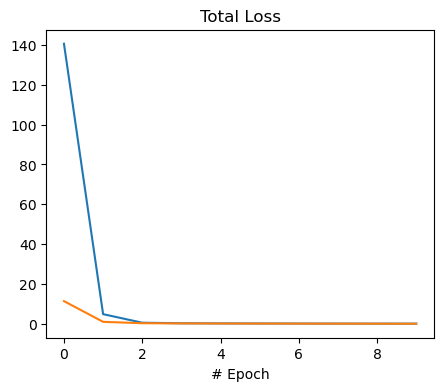

In [28]:
# Train the model

trainer = VAETrainer(model=CLvae, learning_rate=1e-3 ,  batch_size=32,  epoch=10, l2=1e-5)
# Train the VAE model with the trainer class
history = trainer.train(train_dataset, val_dataset)